# This code uses the new discrete code

In this python notebook, we will test the ability to learn trajectory of "Slide Around" using ACTOR-CRITIC RL algorithm.

In [1]:
import os
import sys
import collections
import tensorflow as tf
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)

## PLOTTING 
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import plotting


### IMPORT FROM CURRENT PROJECT
import progress_learner
import config
import project
from project import Project

### RL module
from rl import action_learner, action_learner_search, value_estimator
from rl import block_movement_env
from rl import discrete_value_estimator as  dve
from rl import discrete_action_learner as dal

C:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dal._test_get_action_from_quantized_states()

The action from (2, 1) to (1, 0) is illegal
The action 2 from (2, 1) to (2, 0)
The action from (2, 1) to (3, 0) is illegal
The action 3 from (2, 1) to (1, 1)
The action 0 from (2, 1) to (2, 1)
The action 1 from (2, 1) to (3, 1)
The action from (2, 1) to (1, 2) is illegal
The action 4 from (2, 1) to (2, 2)
The action from (2, 1) to (3, 2) is illegal


In [3]:
dal._test_realize_action()

quantized (1, 1)
action [0.65355339 0.75355339 0.        ]
requantized (1, 1)
action [0.83033009 0.93033009 0.        ]
requantized (2, 1)
action [0.8 0.4 0. ]
requantized (1, 0)
action [0.4767767 0.5767767 0.       ]
requantized (0, 1)
action [0.3 0.9 0. ]
requantized (1, 2)


In [67]:
### RELOAD modules here
reload(config)
reload(value_estimator)
reload(config)
reload(block_movement_env)
reload(action_learner_search)
reload(progress_learner)
reload(dal)
reload(dve)


### MAIN CODE
tf.reset_default_graph()

c = config.Qual_Plan_Config()

global_step = tf.Variable(0, name="global_step", trainable=False)


policy_est = dve.DiscretePolicyEstimator(c)
value_est = dve.ValueEstimator(c)

sess =  tf.Session()

sess.run(tf.global_variables_initializer())

projects = {}
progress_estimators = {}

# action_types = ["SlideToward", "SlideAway", "SlideNext", "SlidePast", "SlideAround"]
action_types = ["SlideAround"]

for project_name in action_types:
    print ('========================================================')
    print ('Load for action type = ' + project_name)
    p_name = project_name.lower() + "_project.proj"

    projects[project_name] = project.Project.load(os.path.join('..' , 'learned_models', p_name))

    with tf.variable_scope("model") as scope:
        print('-------- Load progress model ---------')
        progress_estimators[project_name] = progress_learner.EventProgressEstimator(is_training = False,
                                                                                    is_dropout = False, 
                                                                                    name = projects[project_name].name, 
                                                                                    config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, os.path.join('..' , 'learned_models', 'progress_' + project_name + '.mod.1'))

Load for action type = SlideAround
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
model/SlideAround/linear/weight:0
model/SlideAround/linear/bias:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
model/SlideAround/output_linear/weight:0
model/SlideAround/output_linear/bias:0
INFO:tensorflow:Restoring parameters from ..\learned_models\progress_SlideAround.mod.1


In [11]:
import numpy as np

def print_action_prob(policy_est):
    for progress in range(5):
        for pos in range(6):
            for prev_action in range(5):
                if (pos == 0 or pos == 3) and prev_action == 1:
                    # Illegal
                    continue

                if (pos == 2 or pos == 5) and prev_action == 3:
                    # Illegal
                    continue

                print ('pos = %d, prev_action = %d, progress = %d' % (pos, prev_action, progress) )

                state = np.zeros(150)
                index = int(pos * 25 + prev_action * 5 + progress)

                state[index] = 1

                probs = policy_est.predict(state, sess = sess)

                best_action = np.argmax(probs)
                print ('probs = %s, best_action = %d' % (probs, best_action) )

In [12]:
def print_value_est(value_est):
    for progress in range(5):
        for pos in range(6):
            for prev_action in range(5):
                if (pos == 0 or pos == 3) and prev_action == 1:
                    # Illegal
                    continue

                if (pos == 2 or pos == 5) and prev_action == 3:
                    # Illegal
                    continue
                
                state = np.zeros(150)
                index = int(pos * 25 + prev_action * 5 + progress)

                state[index] = 1

                val = value_est.predict(state, sess = sess)
                print ('pos = %d, prev_action = %d, progress = %d, val = %.2f' % (pos, prev_action, progress, val) )

Following we use the following learning rate and decy

    policy_learning_rate = 0.2
	policy_decay = 0.98
	policy_decay_every = 100
	value_learning_rate = 0.1
	value_decay = 0.98
	value_decay_every = 100

# THIS FOLLOWING PART HAS A TERRIBLE BUG

In [73]:
#reload(dal)
c.num_episodes = 2000

# Effective number of steps would be limit_step // (breadth + 1)
action_ln = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs, stats = action_ln.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'ACTOR_CRITIC', default = False)

Step 1 @ Episode 1/2000 (0.0)

KeyboardInterrupt: 

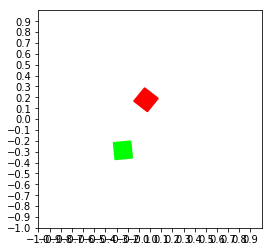

(None, None)
[ 0.25466323 -0.23941366  0.095742  ]
[[ 0.   0.  -1.   0.  -1.   0.   1. ]
 [ 0.   0.  -1.   0.  -1.   0.   1. ]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.   0.   0.  -1.   0.   0.5]
 [ 0.   0.   0.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]]
Progress = 0.59; reward = 0.59


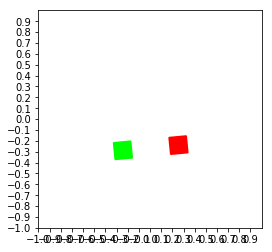

(None, None)
[ 0.14268552 -0.60534754  0.095742  ]
[[ 0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.   0.   0.  -1.   0.   0.5]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]]
Progress = 0.61; reward = 0.02


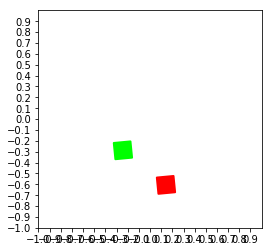

(None, None)
[-0.05018068 -0.44627955  0.095742  ]
[[ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.   0.   0.  -1.   0.   0.5]
 [-1.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   0.   0.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]]
Progress = 0.05; reward = -0.56


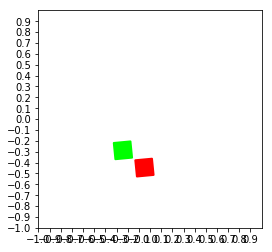

(None, None)
[-0.21914794 -0.53606662  0.095742  ]
[[ 0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.  -1.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [ 0.   0.  -1.   0.  -1.   0.   0.5]
 [-1.   1.   1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.  -1.   0.  -1.   0.   0. ]
 [-1.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.  -1.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   0.   0.   0.   0. ]
 [ 0.  -1.  -1.   0.   0.   0.   0. ]
 [-1.   0.  -1.   0.  -1.   0.   0. ]
 [ 0.   0.   1.   0.  -1.   0.   0. ]]
Progress = 0.31; reward = 0.26


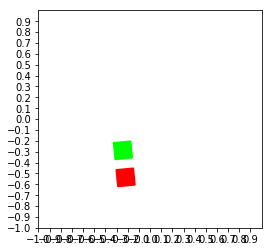

In [188]:
past_envs[1995].env.replay(verbose = True)

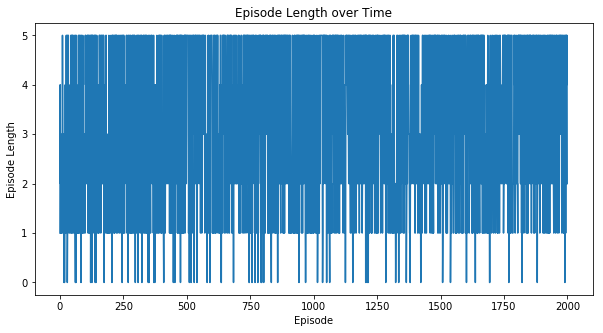

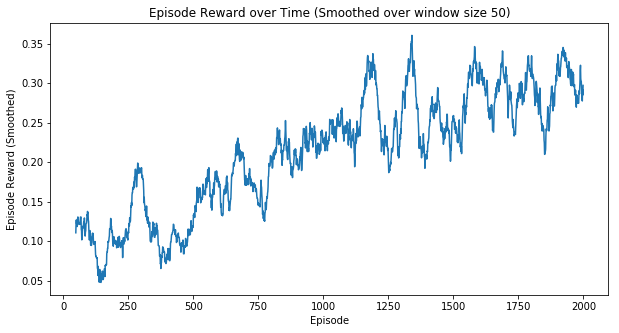

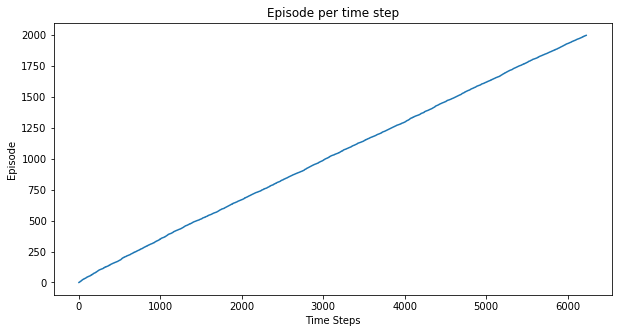

(<matplotlib.figure.Figure at 0x21e435d2780>,
 <matplotlib.figure.Figure at 0x21e598808d0>)

In [183]:
plotting.plot_episode_stats(stats, smoothing_window=50)

In [5]:
reload(block_movement_env)
#reload(progress_learner)
bme = block_movement_env.BlockMovementEnv(c, projects['SlideAround'].speed, projects['SlideAround'].name, 
                progress_estimator = progress_estimators['SlideAround'], session = sess)

In [192]:
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.11560918 0.05975545 0.70296913 0.0405202  0.08114599], best_action = 2
pos = 0, prev_action = 2, progress = 0
probs = [0.21192178 0.18276869 0.22514473 0.18118778 0.198977  ], best_action = 2
pos = 0, prev_action = 3, progress = 0
probs = [0.16873729 0.1704726  0.21312693 0.2278958  0.21976736], best_action = 3
pos = 0, prev_action = 4, progress = 0
probs = [0.21313553 0.21457502 0.2179609  0.16984092 0.18448764], best_action = 2
pos = 1, prev_action = 0, progress = 0
probs = [0.02882295 0.00775403 0.94172907 0.00794909 0.01374476], best_action = 2
pos = 1, prev_action = 1, progress = 0
probs = [0.19226359 0.17790374 0.2197517  0.17445207 0.23562892], best_action = 4
pos = 1, prev_action = 2, progress = 0
probs = [0.19164194 0.2080846  0.22903635 0.17773563 0.19350143], best_action = 2
pos = 1, prev_action = 3, progress = 0
probs = [0.20863695 0.17365862 0.22597036 0.19261537 0.19911872], best_action = 2
pos = 1, prev_action = 4, progre

In [197]:
import time

start_time = time.time()

c.num_episodes = 10000

# Continue running for 8000 more episodes
# Effective number of steps would be limit_step // (breadth + 1)
action_ln_2 = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_2, stats_2 = action_ln_2.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'ACTOR_CRITIC', default = False)

print ('Run finish after %d' % (time.time() -start_time))

Step 1 @ Episode 10000/10000 (0.21492771804332733)Run finish after 34032


Step 1 @ Episode 10000/10000 (0.21492771804332733)Run finish after 34032

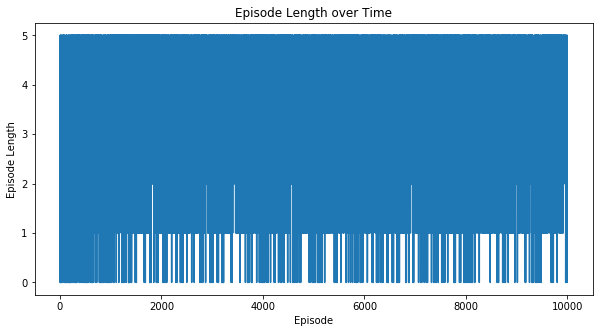

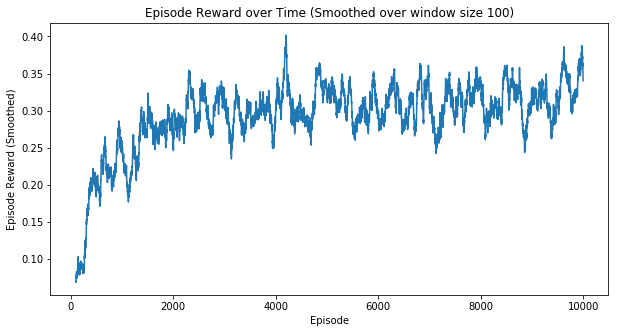

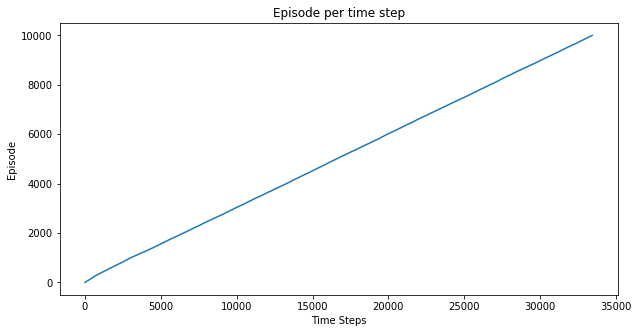

(<matplotlib.figure.Figure at 0x21ebc240860>,
 <matplotlib.figure.Figure at 0x21ed1730e48>)

In [199]:
plotting.plot_episode_stats(stats_2, smoothing_window=100)

In [200]:
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.04033542 0.01609073 0.8853315  0.02386988 0.03437242], best_action = 2
pos = 0, prev_action = 2, progress = 0
probs = [0.18508157 0.19495568 0.17084895 0.24698135 0.20213245], best_action = 3
pos = 0, prev_action = 3, progress = 0
probs = [0.1885644  0.18258478 0.2078884  0.18889949 0.23206295], best_action = 4
pos = 0, prev_action = 4, progress = 0
probs = [0.18026705 0.21004896 0.18109591 0.20234026 0.2262478 ], best_action = 4
pos = 1, prev_action = 0, progress = 0
probs = [0.01446648 0.00506477 0.96763235 0.00772114 0.00511526], best_action = 2
pos = 1, prev_action = 1, progress = 0
probs = [0.2316514  0.19011293 0.16963097 0.24191612 0.1666886 ], best_action = 3
pos = 1, prev_action = 2, progress = 0
probs = [0.21398306 0.23207778 0.18596579 0.1972843  0.17068909], best_action = 1
pos = 1, prev_action = 3, progress = 0
probs = [0.198546   0.19231519 0.25475985 0.17536072 0.17901821], best_action = 2
pos = 1, prev_action = 4, progre

In [201]:
c.num_episodes = 1000

# Continue running for 8000 more episodes
# Effective number of steps would be limit_step // (breadth + 1)
action_ln_3 = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_3, stats_3 = action_ln_2.policy_learn(dal.random_action, breadth = 3, verbose = False,
                                          choice = 'ACTOR_CRITIC', default = False)

print ('Run finish after %d' % (time.time() -start_time))

Step 1 @ Episode 1000/1000 (0.7421432137489319)Run finish after 71401


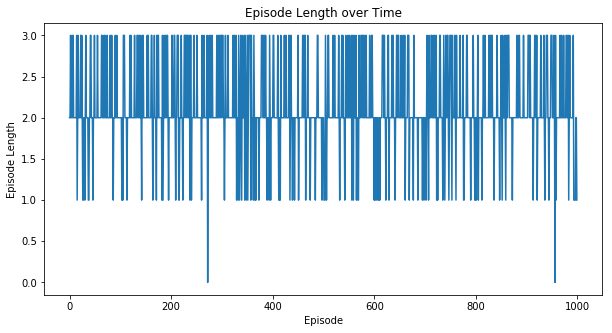

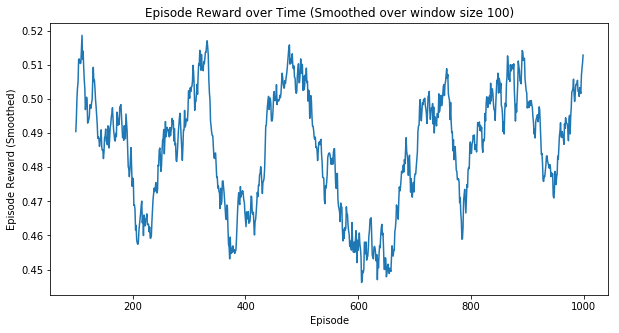

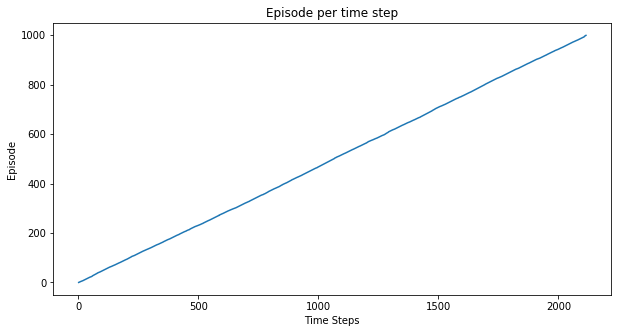

(<matplotlib.figure.Figure at 0x21ee6fcb860>,
 <matplotlib.figure.Figure at 0x21ee71314a8>)

In [203]:
plotting.plot_episode_stats(stats_3, smoothing_window=100)

In [205]:
c.num_episodes = 2000

# Continue running for 8000 more episodes
# Effective number of steps would be limit_step // (breadth + 1)
action_ln_4 = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_4, stats_4 = action_ln_4.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'REINFORCE', default = False)

print ('Run finish after %d' % (time.time() -start_time))

Step 0 @ Episode 2000/2000 (0.674066960811615)Run finish after 75554


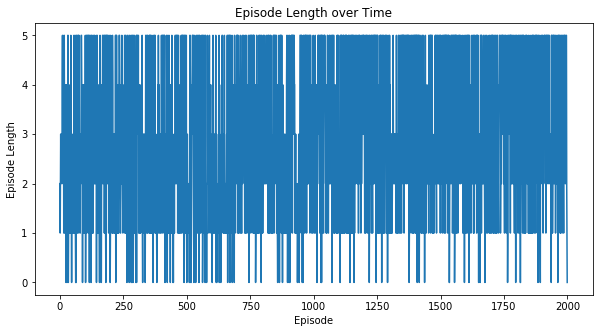

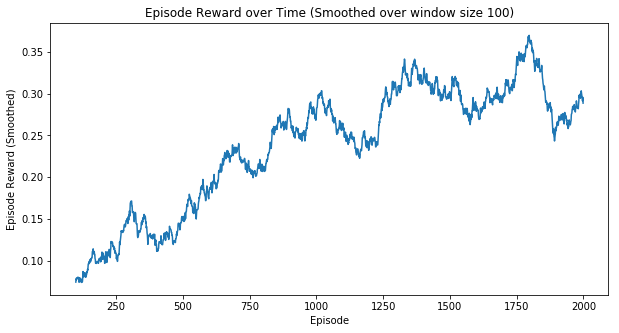

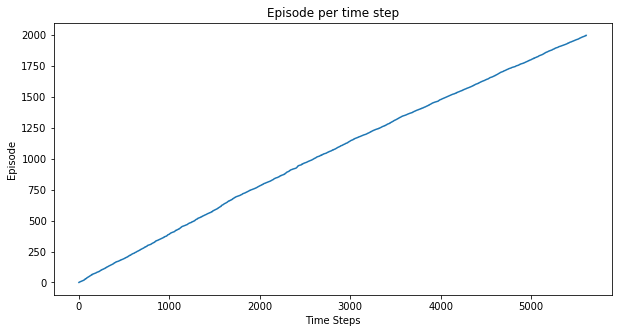

(<matplotlib.figure.Figure at 0x21ee868d0b8>,
 <matplotlib.figure.Figure at 0x21ee864fe48>)

In [206]:
plotting.plot_episode_stats(stats_4, smoothing_window=100)

In [208]:
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.43276381 0.12610538 0.22748412 0.07284497 0.14080176], best_action = 0
pos = 0, prev_action = 2, progress = 0
probs = [0.2317134  0.19269374 0.22860385 0.17521039 0.1717787 ], best_action = 0
pos = 0, prev_action = 3, progress = 0
probs = [0.21422206 0.17884219 0.18776898 0.23214772 0.18701904], best_action = 3
pos = 0, prev_action = 4, progress = 0
probs = [0.23193984 0.23091899 0.17400612 0.18296893 0.18016616], best_action = 0
pos = 1, prev_action = 0, progress = 0
probs = [0.01180444 0.0033196  0.9761411  0.00361269 0.00512216], best_action = 2
pos = 1, prev_action = 1, progress = 0
probs = [0.21289343 0.20069966 0.21334763 0.1771605  0.19589876], best_action = 2
pos = 1, prev_action = 2, progress = 0
probs = [0.18736954 0.17491302 0.23307775 0.21347693 0.1911628 ], best_action = 2
pos = 1, prev_action = 3, progress = 0
probs = [0.20318663 0.23521215 0.15189482 0.24037269 0.1693337 ], best_action = 3
pos = 1, prev_action = 4, progre

In [210]:
start_time = time.time()

c.num_episodes = 10000

# Continue running for 8000 more episodes
# Effective number of steps would be limit_step // (breadth + 1)
action_ln_5 = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_5, stats_5 = action_ln_5.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'REINFORCE', default = False)

print ('Run finish after %d' % (time.time() -start_time))

Step 2 @ Episode 10000/10000 (0.29660531878471375)Run finish after 33009


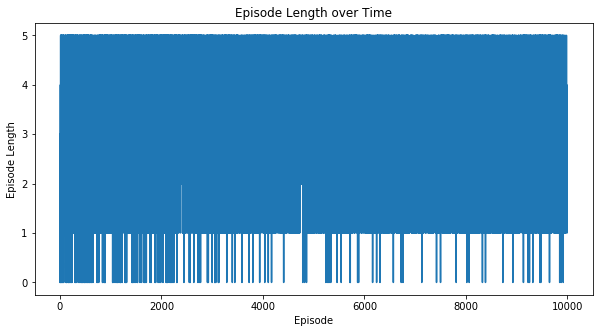

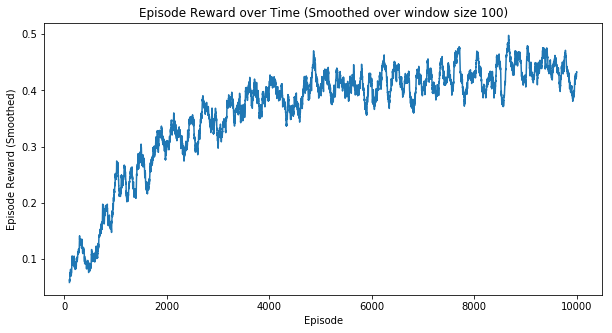

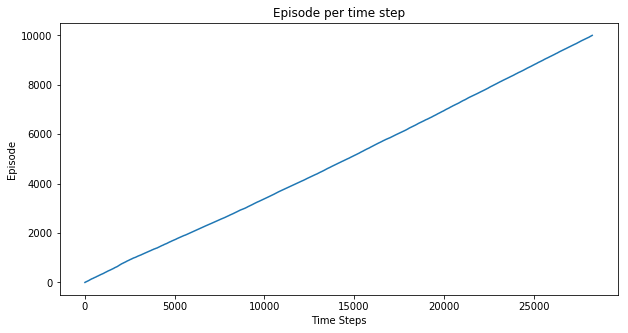

(<matplotlib.figure.Figure at 0x21dd1329b70>,
 <matplotlib.figure.Figure at 0x21f1ef07a20>)

In [211]:
plotting.plot_episode_stats(stats_5, smoothing_window=100)

In [213]:
print_value_est(value_est)

pos = 0, prev_action = 0, progress = 0, val = 0.19
pos = 0, prev_action = 2, progress = 0, val = -0.26
pos = 0, prev_action = 3, progress = 0, val = 0.70
pos = 0, prev_action = 4, progress = 0, val = 0.70
pos = 1, prev_action = 0, progress = 0, val = 0.33
pos = 1, prev_action = 1, progress = 0, val = 0.70
pos = 1, prev_action = 2, progress = 0, val = 0.70
pos = 1, prev_action = 3, progress = 0, val = -0.36
pos = 1, prev_action = 4, progress = 0, val = 0.70
pos = 2, prev_action = 0, progress = 0, val = 0.41
pos = 2, prev_action = 1, progress = 0, val = -0.01
pos = 2, prev_action = 2, progress = 0, val = 0.70
pos = 2, prev_action = 4, progress = 0, val = 0.70
pos = 3, prev_action = 0, progress = 0, val = 0.14
pos = 3, prev_action = 2, progress = 0, val = 0.93
pos = 3, prev_action = 3, progress = 0, val = -1.94
pos = 3, prev_action = 4, progress = 0, val = -0.60
pos = 4, prev_action = 0, progress = 0, val = 0.17
pos = 4, prev_action = 1, progress = 0, val = 0.70
pos = 4, prev_action = 2, 

In [214]:
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.02472571 0.01592394 0.94035184 0.00687977 0.01211879], best_action = 2
pos = 0, prev_action = 2, progress = 0
probs = [0.16684605 0.23037696 0.23486249 0.16991886 0.19799559], best_action = 2
pos = 0, prev_action = 3, progress = 0
probs = [0.1731413  0.23698355 0.19200249 0.19616497 0.20170774], best_action = 1
pos = 0, prev_action = 4, progress = 0
probs = [0.19573733 0.20587489 0.23010142 0.18460074 0.18368568], best_action = 2
pos = 1, prev_action = 0, progress = 0
probs = [0.00659276 0.00106274 0.98888457 0.00201542 0.00144443], best_action = 2
pos = 1, prev_action = 1, progress = 0
probs = [0.17941135 0.20229545 0.22631451 0.21276304 0.17921574], best_action = 2
pos = 1, prev_action = 2, progress = 0
probs = [0.15863001 0.15877181 0.23292504 0.2320842  0.21758893], best_action = 2
pos = 1, prev_action = 3, progress = 0
probs = [0.26197922 0.10965492 0.15912701 0.19395961 0.27527922], best_action = 4
pos = 1, prev_action = 4, progre

# I HAVE FIXED THE BUG IN THIS PART

In [45]:
reload(dal)
c.num_episodes = 2000

# Effective number of steps would be limit_step // (breadth + 1)
action_ln = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs, stats, es_stats = action_ln.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'ACTOR_CRITIC', default = False)

Step 2 @ Episode 2000/2000 (0.7048406079411507)2)))

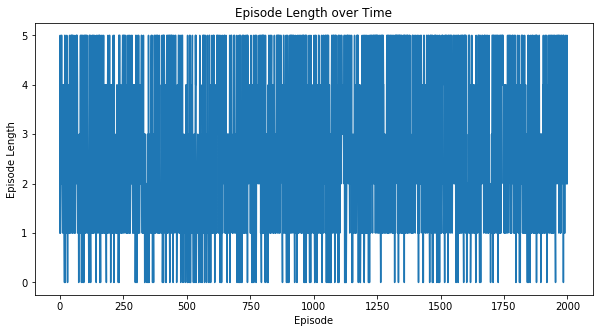

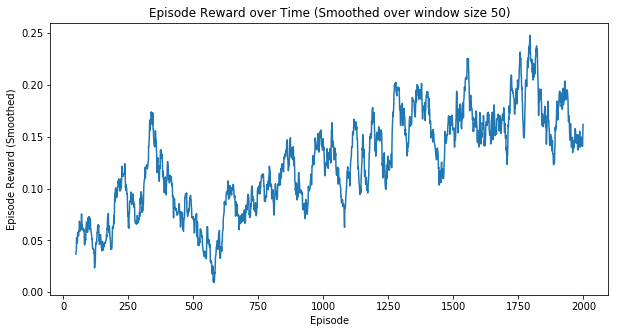

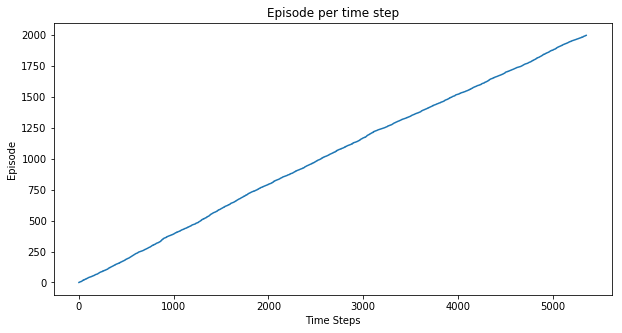

(<matplotlib.figure.Figure at 0x25a151c1710>,
 <matplotlib.figure.Figure at 0x25a1ce88240>)

In [46]:
plotting.plot_episode_stats(stats, smoothing_window=50)

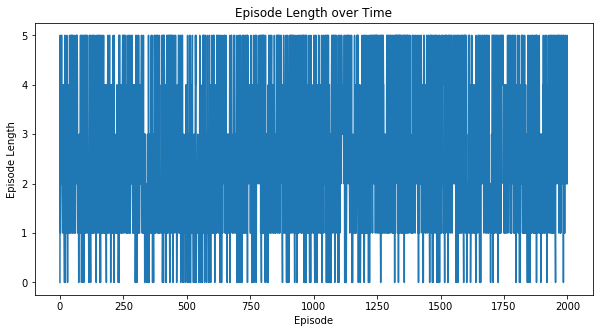

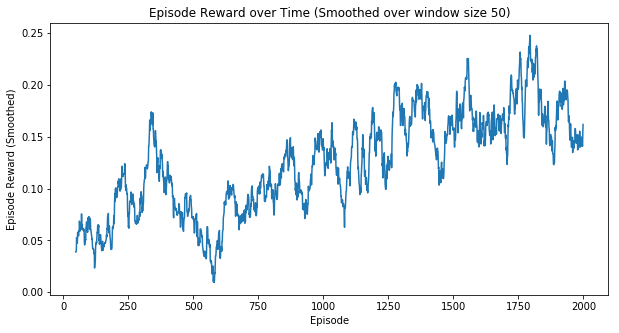

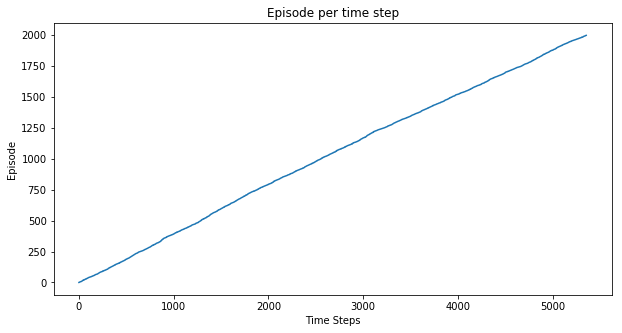

(<matplotlib.figure.Figure at 0x25a37308780>,
 <matplotlib.figure.Figure at 0x25a373b34a8>)

In [48]:
plotting.plot_episode_stats(es_stats, smoothing_window=50)

In [49]:
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.22874387 0.08277652 0.49681917 0.09487656 0.09678387], best_action = 2
pos = 0, prev_action = 2, progress = 0
probs = [0.17622466 0.21090889 0.30094355 0.15920722 0.15271579], best_action = 2
pos = 0, prev_action = 3, progress = 0
probs = [0.22452343 0.23172991 0.20354974 0.1380565  0.20214038], best_action = 1
pos = 0, prev_action = 4, progress = 0
probs = [0.18307653 0.2911028  0.1525204  0.17128916 0.20201114], best_action = 1
pos = 1, prev_action = 0, progress = 0
probs = [0.4506158  0.02896147 0.44453886 0.03161738 0.04426644], best_action = 0
pos = 1, prev_action = 1, progress = 0
probs = [0.17938146 0.20160842 0.19312426 0.23409796 0.19178785], best_action = 3
pos = 1, prev_action = 2, progress = 0
probs = [0.15870875 0.14861564 0.55072635 0.08546651 0.05648275], best_action = 2
pos = 1, prev_action = 3, progress = 0
probs = [0.1944515  0.17958692 0.22255832 0.16643551 0.23696777], best_action = 4
pos = 1, prev_action = 4, progre

In [50]:
print_value_est(value_est)

pos = 0, prev_action = 0, progress = 0, val = -19.67
pos = 0, prev_action = 2, progress = 0, val = -20.05
pos = 0, prev_action = 3, progress = 0, val = -19.77
pos = 0, prev_action = 4, progress = 0, val = -19.77
pos = 1, prev_action = 0, progress = 0, val = -19.53
pos = 1, prev_action = 1, progress = 0, val = -19.82
pos = 1, prev_action = 2, progress = 0, val = -19.93
pos = 1, prev_action = 3, progress = 0, val = -19.78
pos = 1, prev_action = 4, progress = 0, val = -19.82
pos = 2, prev_action = 0, progress = 0, val = -19.59
pos = 2, prev_action = 1, progress = 0, val = -19.79
pos = 2, prev_action = 2, progress = 0, val = -19.94
pos = 2, prev_action = 4, progress = 0, val = -19.77
pos = 3, prev_action = 0, progress = 0, val = -19.61
pos = 3, prev_action = 2, progress = 0, val = -19.81
pos = 3, prev_action = 3, progress = 0, val = -19.84
pos = 3, prev_action = 4, progress = 0, val = -19.86
pos = 4, prev_action = 0, progress = 0, val = -19.54
pos = 4, prev_action = 1, progress = 0, val = 

In [53]:
import time
start_time = time.time()

c.num_episodes = 2000

# Continue running for 10000 more episodes
# Effective number of steps would be limit_step // (breadth + 1)
action_ln_2 = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_2, stats_2, es_stats_2 = action_ln_2.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'REINFORCE', default = False)

print ('Run finish after %d' % (time.time() -start_time))

Step 1 @ Episode 2000/2000 (0.034974969923496246)Run finish after 1437


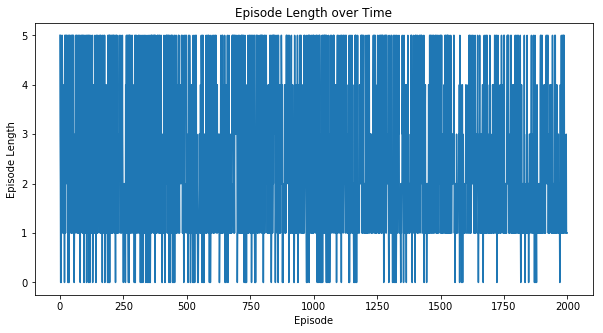

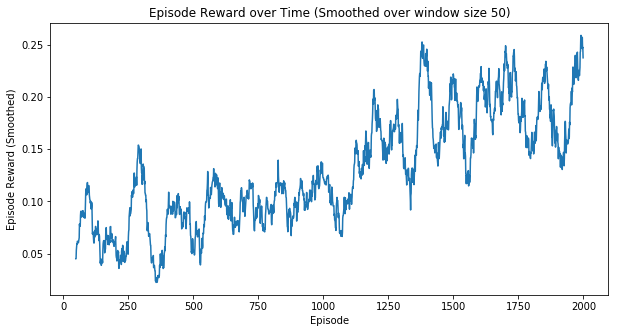

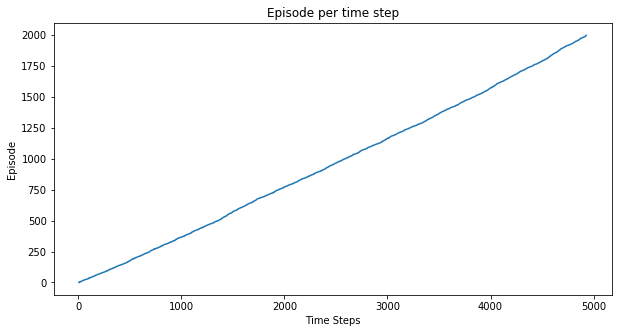

(<matplotlib.figure.Figure at 0x25a5371b6d8>,
 <matplotlib.figure.Figure at 0x25a5378b1d0>)

In [57]:
plotting.plot_episode_stats(stats_2, smoothing_window=50)

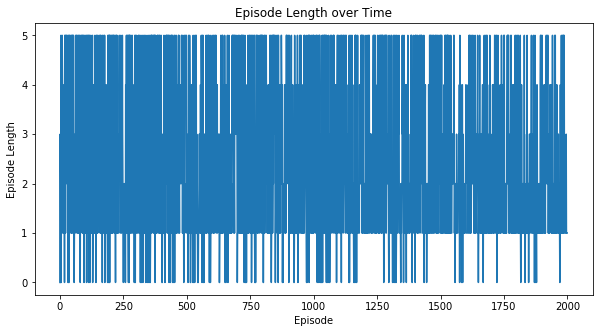

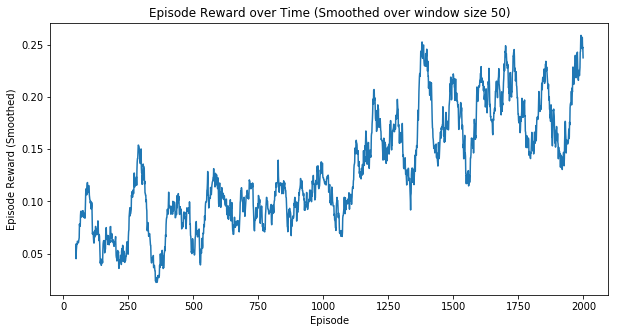

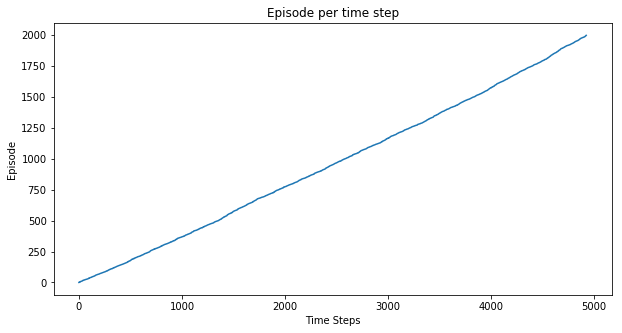

(<matplotlib.figure.Figure at 0x25a5378dc88>,
 <matplotlib.figure.Figure at 0x25a5384eef0>)

In [58]:
plotting.plot_episode_stats(es_stats_2, smoothing_window=50)

In [59]:
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.16666368 0.15466483 0.39511186 0.10110937 0.18245025], best_action = 2
pos = 0, prev_action = 2, progress = 0
probs = [0.32320246 0.14756066 0.25840703 0.16723073 0.10359909], best_action = 0
pos = 0, prev_action = 3, progress = 0
probs = [0.18699104 0.33934572 0.192604   0.11421999 0.16683927], best_action = 1
pos = 0, prev_action = 4, progress = 0
probs = [0.20023134 0.20426708 0.19369787 0.16786763 0.23393603], best_action = 4
pos = 1, prev_action = 0, progress = 0
probs = [0.10160106 0.03877126 0.7587797  0.03612012 0.06472789], best_action = 2
pos = 1, prev_action = 1, progress = 0
probs = [0.16969673 0.15972857 0.23005122 0.21473062 0.22579287], best_action = 2
pos = 1, prev_action = 2, progress = 0
probs = [0.5379006  0.13168955 0.19621053 0.06451786 0.06968144], best_action = 0
pos = 1, prev_action = 3, progress = 0
probs = [0.19160369 0.16221096 0.26619485 0.18161188 0.19837858], best_action = 2
pos = 1, prev_action = 4, progre

In [60]:
print_value_est(value_est)

pos = 0, prev_action = 0, progress = 0, val = 0.16
pos = 0, prev_action = 2, progress = 0, val = -0.02
pos = 0, prev_action = 3, progress = 0, val = 0.08
pos = 0, prev_action = 4, progress = 0, val = -0.00
pos = 1, prev_action = 0, progress = 0, val = 0.23
pos = 1, prev_action = 1, progress = 0, val = 0.15
pos = 1, prev_action = 2, progress = 0, val = 0.01
pos = 1, prev_action = 3, progress = 0, val = 0.09
pos = 1, prev_action = 4, progress = 0, val = 0.01
pos = 2, prev_action = 0, progress = 0, val = 0.30
pos = 2, prev_action = 1, progress = 0, val = 0.06
pos = 2, prev_action = 2, progress = 0, val = -0.08
pos = 2, prev_action = 4, progress = 0, val = 0.05
pos = 3, prev_action = 0, progress = 0, val = 0.13
pos = 3, prev_action = 2, progress = 0, val = -0.07
pos = 3, prev_action = 3, progress = 0, val = -0.01
pos = 3, prev_action = 4, progress = 0, val = 0.01
pos = 4, prev_action = 0, progress = 0, val = 0.30
pos = 4, prev_action = 1, progress = 0, val = 0.12
pos = 4, prev_action = 2, 

Following we use the following learning rate and decy

    policy_learning_rate = 1
	policy_decay = 0.98
	policy_decay_every = 100
	value_learning_rate = 0.01
	value_decay = 0.98
	value_decay_every = 100

In [54]:
reload(config)

<module 'config' from 'D:\\git\\learn-to-perform\\config.py'>

In [62]:
c.num_episodes = 2000

# Effective number of steps would be limit_step // (breadth + 1)
action_ln = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_3, stats_3, es_stats_3 = action_ln.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'REINFORCE', default = False)

Step 1 @ Episode 2000/2000 (0.6216391921043396))))

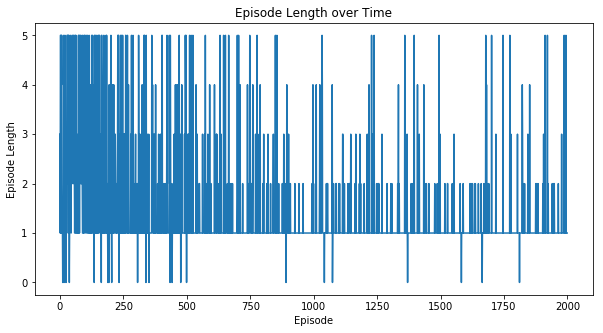

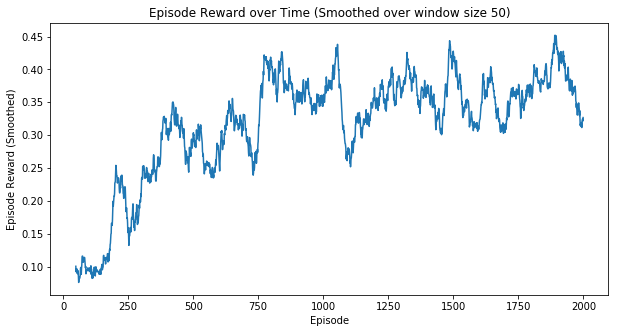

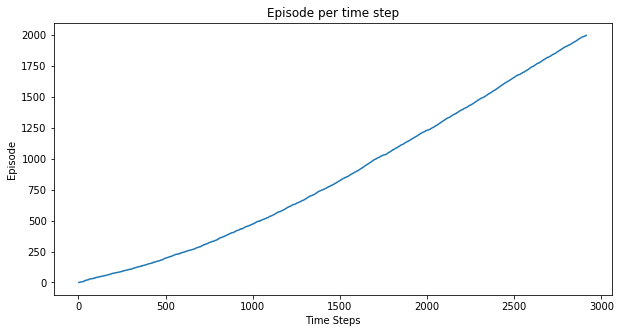

(<matplotlib.figure.Figure at 0x25a53886710>,
 <matplotlib.figure.Figure at 0x25a70aed780>)

In [63]:
plotting.plot_episode_stats(stats_3, smoothing_window=50)

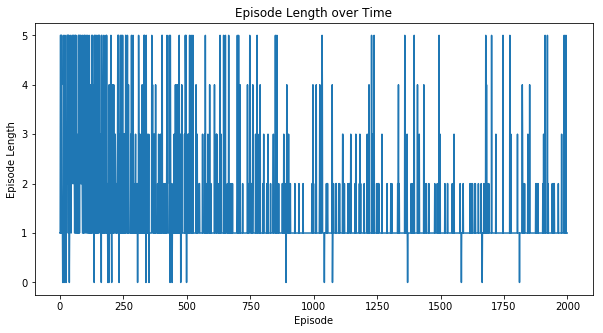

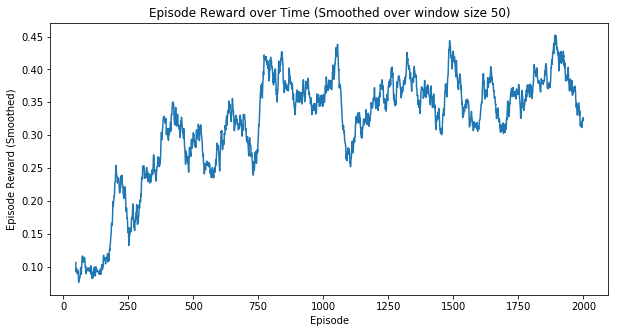

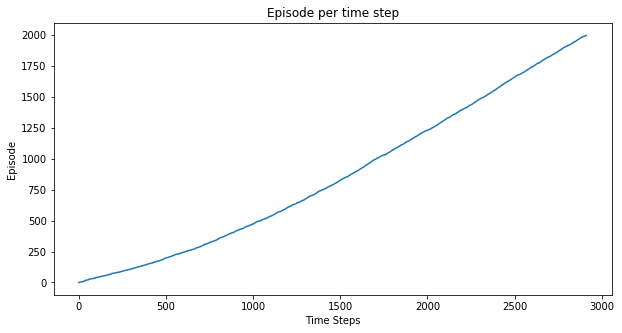

(<matplotlib.figure.Figure at 0x25a71b92240>,
 <matplotlib.figure.Figure at 0x25a71db4438>)

In [64]:
plotting.plot_episode_stats(es_stats_3, smoothing_window=50)

In [65]:
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.05358976 0.01039878 0.91490215 0.01113761 0.00997167], best_action = 2
pos = 0, prev_action = 2, progress = 0
probs = [0.7853317  0.00688746 0.18317464 0.01741919 0.00718706], best_action = 0
pos = 0, prev_action = 3, progress = 0
probs = [0.16928029 0.27765036 0.35367575 0.08424605 0.11514758], best_action = 2
pos = 0, prev_action = 4, progress = 0
probs = [0.24788252 0.16707794 0.2406738  0.12289558 0.2214702 ], best_action = 0
pos = 1, prev_action = 0, progress = 0
probs = [0.10506502 0.00519368 0.8695827  0.00886288 0.0112957 ], best_action = 2
pos = 1, prev_action = 1, progress = 0
probs = [0.13049379 0.17757584 0.2432168  0.1572398  0.29147375], best_action = 4
pos = 1, prev_action = 2, progress = 0
probs = [9.9159884e-01 4.6162488e-04 5.6784539e-03 9.3027262e-04 1.3307392e-03], best_action = 0
pos = 1, prev_action = 3, progress = 0
probs = [0.14608401 0.29586437 0.18896797 0.16842793 0.20065571], best_action = 1
pos = 1, prev_act

In [66]:
print_value_est(value_est)

pos = 0, prev_action = 0, progress = 0, val = 0.28
pos = 0, prev_action = 2, progress = 0, val = -0.06
pos = 0, prev_action = 3, progress = 0, val = 0.04
pos = 0, prev_action = 4, progress = 0, val = 0.03
pos = 1, prev_action = 0, progress = 0, val = 0.29
pos = 1, prev_action = 1, progress = 0, val = 0.05
pos = 1, prev_action = 2, progress = 0, val = -0.05
pos = 1, prev_action = 3, progress = 0, val = 0.05
pos = 1, prev_action = 4, progress = 0, val = 0.03
pos = 2, prev_action = 0, progress = 0, val = 0.36
pos = 2, prev_action = 1, progress = 0, val = 0.04
pos = 2, prev_action = 2, progress = 0, val = -0.05
pos = 2, prev_action = 4, progress = 0, val = 0.03
pos = 3, prev_action = 0, progress = 0, val = 0.25
pos = 3, prev_action = 2, progress = 0, val = -0.05
pos = 3, prev_action = 3, progress = 0, val = 0.06
pos = 3, prev_action = 4, progress = 0, val = 0.02
pos = 4, prev_action = 0, progress = 0, val = 0.33
pos = 4, prev_action = 1, progress = 0, val = 0.09
pos = 4, prev_action = 2, p

In [68]:
start_time = time.time()

c.num_episodes = 2000

# Effective number of steps would be limit_step // (breadth + 1)
action_ln = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs_4, stats_4, es_stats_4 = action_ln.policy_learn(dal.random_action, breadth = 1, verbose = False,
                                          choice = 'ACTOR_CRITIC', default = False)

print ('Run finish after %d' % (time.time() -start_time))

Step 5 @ Episode 2000/2000 (0.5675366520881653)Run finish after 1812


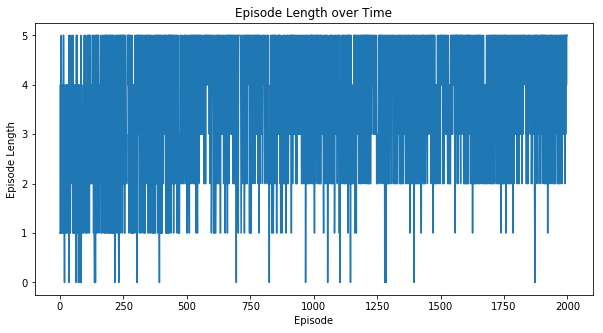

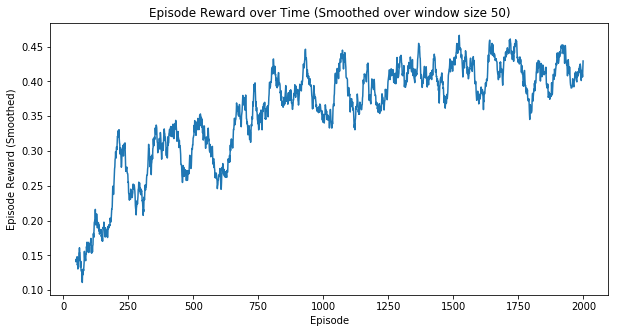

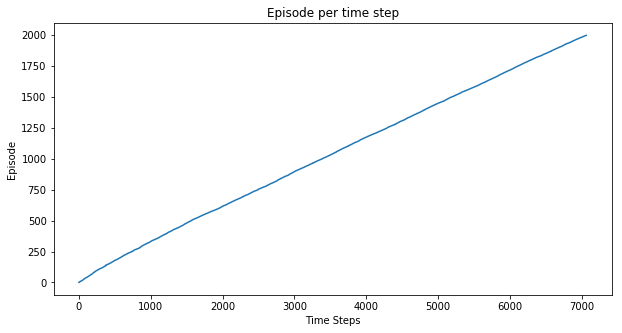

(<matplotlib.figure.Figure at 0x25a71e0f9e8>,
 <matplotlib.figure.Figure at 0x25a8b350a90>)

In [69]:
plotting.plot_episode_stats(stats_4, smoothing_window=50)

In [70]:
print_action_prob(policy_est)

pos = 0, prev_action = 0, progress = 0
probs = [0.00764323 0.00519593 0.97387785 0.00559878 0.00768407], best_action = 2
pos = 0, prev_action = 2, progress = 0
probs = [0.01689946 0.00354934 0.9668519  0.01059306 0.00210617], best_action = 2
pos = 0, prev_action = 3, progress = 0
probs = [0.21164423 0.21410146 0.1936271  0.11214285 0.26848435], best_action = 4
pos = 0, prev_action = 4, progress = 0
probs = [0.17305419 0.2124331  0.17899552 0.11106146 0.3244558 ], best_action = 4
pos = 1, prev_action = 0, progress = 0
probs = [5.812273e-03 1.593200e-03 9.900961e-01 1.541900e-03 9.565292e-04], best_action = 2
pos = 1, prev_action = 1, progress = 0
probs = [0.1153427  0.08764274 0.62684405 0.08594922 0.08422133], best_action = 2
pos = 1, prev_action = 2, progress = 0
probs = [4.8841145e-03 1.2303940e-03 9.9185419e-01 1.2309368e-03 8.0035551e-04], best_action = 2
pos = 1, prev_action = 3, progress = 0
probs = [0.16639706 0.15653549 0.31302512 0.16914095 0.19490142], best_action = 2
pos = 1

In [71]:
print_value_est(value_est)

pos = 0, prev_action = 0, progress = 0, val = 0.39
pos = 0, prev_action = 2, progress = 0, val = 0.10
pos = 0, prev_action = 3, progress = 0, val = 0.03
pos = 0, prev_action = 4, progress = 0, val = 0.03
pos = 1, prev_action = 0, progress = 0, val = 0.42
pos = 1, prev_action = 1, progress = 0, val = 0.06
pos = 1, prev_action = 2, progress = 0, val = 0.10
pos = 1, prev_action = 3, progress = 0, val = 0.05
pos = 1, prev_action = 4, progress = 0, val = 0.02
pos = 2, prev_action = 0, progress = 0, val = 0.48
pos = 2, prev_action = 1, progress = 0, val = 0.04
pos = 2, prev_action = 2, progress = 0, val = 0.04
pos = 2, prev_action = 4, progress = 0, val = 0.03
pos = 3, prev_action = 0, progress = 0, val = 0.39
pos = 3, prev_action = 2, progress = 0, val = 0.08
pos = 3, prev_action = 3, progress = 0, val = 0.04
pos = 3, prev_action = 4, progress = 0, val = 0.05
pos = 4, prev_action = 0, progress = 0, val = 0.40
pos = 4, prev_action = 1, progress = 0, val = 0.06
pos = 4, prev_action = 2, progr

## From this point, we will run from command line, and paste the result here